<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3 - Web APIs & NLP

## Content

- [Library & dataset imports](#Importing-libraries-and-clean-dataset)
- [Data Dictionary](#Data-Dictionary)
- [Editing stop words](#Adding-words-to-scikit-learn's-CountVectorizer's-stop-list)
- [Baseline Accuracy](#Baseline-Accuracy)
- [Modeling with Multinominal Naive Bayse (Warning!: n_jobs have been set to -1)](#Multinominal-Naive-Bayes-model)
- [Modeling with KNearestNeighbors (Warning!: n_jobs have been set to -1)](#KNearestNeighbors-model)
- [Modeling with Random Forest (Warning!: n_jobs have been set to -1)](#Random-Forest)
- [Score Summary](#Score-Summary)
- [Conclusion](#Conclusion)

### Importing libraries and clean dataset

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 
# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 400
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [5]:
final_data = pd.read_csv("../datasets/final_data.csv")

In [6]:
final_data.shape

(1992, 2)

### Data Dictionary



|Column|Dataset|Data Description|
|---|---|---|
|subreddit|final_data.csv|Subreddit of post taken from with (0: Vegan, 1: Keto)|
|lemm_words|final_data.csv|Lemmertized words of cleaned title and posts concatenated|

In [7]:
final_data.tail()

,subreddit,lemm_words
1987,1,third time doing keto a a type 2 diabetic i'm worried that it's too late i wa first diagnosed with type 2 diabetes about 4 year ago at the time i wa really afraid so i began researching the internet for the best diet to treat this disease which is when i first learned about keto i wa so impressed with the science behind it that i decided to give it a try and it worked it only took a day or two...
1988,1,keto while maintaining a calorie deficit doe anyone have tip on how to do low cal keto i feel like every recipe i find is either all bacon or all cheese which are both super high in calorie where are the resource for low cal healthy keto been doing keto for 1 5 month with no mess ups now
1989,1,stalled weight loss hi i have lost ten pound but i have been stuck at the 230 pound mark for about 5 day i am definitely in a caloric deficit so idk what s going on doe anyone know why i might be stalling despite the large calorie defect
1990,1,raw spinach and oxylates are they really that bad i like to use raw spinach a a base for a lot of sauce based dish almost like one would normally use rice or pasta or a tortilla it's super convenient low in carbs and seems like a fairly nutrient dense food a opposed to shirataki rice for example which ha nothing in it besides fiber and water however i m concerned a little bit about oxylates an...
1991,1,need some lunch and dinner idea hey guy i ve been eating really really basic food lately such a baked chicken beef and broccoli egg egg more egg sausage bacon taco with beef taco with chicken stuff like that but it s alllll sooo basic and day 7 is really starting to feel rough because i open my fridge and i just think blah i m no chef otherwise i would have much more diverse option so i need y...


In [8]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1992 entries, 0 to 1991
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   subreddit   1992 non-null   int64 
 1   lemm_words  1992 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.2+ KB


### Adding words to scikit learn's CountVectorizer's stop list

In [9]:
# Reference: https://stackoverflow.com/questions/24386489/adding-words-to-scikit-learns-countvectorizers-stop-list/24386751

my_stop_words = ['https', 've', 'don', 'doesn', 'getting', 'going', 'got', 'ha', 'isn', 'wa','amp','i m']
stop_words = text.ENGLISH_STOP_WORDS.union(my_stop_words)

In [10]:
# Assembling the predictor(X) and target (y)
X = final_data['lemm_words']
y = final_data['subreddit']

In [11]:
# Doing a train test split with stratitfy set to the distribution of target. 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

### Baseline Accuracy

In [12]:
# Baseline accuracy = 0.502008

y_test.value_counts(normalize=True)

1    0.502008
0    0.497992
Name: subreddit, dtype: float64

In [13]:
def conf_matrix(predict,model,cmaps='YlOrBr'):
    '''
    Input is what we want to predict and the model we are using
    Output is a confusion matrix and the scores
    '''
    preds = model.predict(predict)
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = confusion_matrix(y_test,preds).ravel()
    plot_confusion_matrix(model, predict, y_test, cmap=cmaps, values_format = 'd');
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}\n" )
    print(f"Accuracy: {(tp+tn)/cm.sum()}")
    print(f"Misclassification: {1-((tp+tn)/cm.sum())}")
    print(f"Precision: {tp/(tp+fp)}")
    print(f"Sensitivity: {tp/(tp+fn)}")
    print(f"Specificity: {tn/(tn+fp)}")

## Multinominal Naive Bayes model

Naive Bayes is a statistical classification technique based on Bayes Theorem. It is one of the simplest supervised learning algorithms. Naive Bayes classifier is the fast, accurate and reliable algorithm. Naive Bayes classifiers have high accuracy and speed on large datasets.
Naive Bayes classifier calculates the probability of an event in the following steps:

- Step 1: Calculate the prior probability for given class labels
- Step 2: Find conditional probability with each attribute for each class
- Step 3: Multiply same class conditional probability.
- Step 4: Multiply prior probability with step 3 probability 
- Step 5: See which class has a higher probability, given the input belongs to the higher probability class.<sup>5</sup>

### Using CountVectorizer with Multinomial Naive Bayes

In [14]:
# Creating a pipeline with countvectorizer as the transformer and multinomialnb as the estimator
pipe_cvec_nb = Pipeline([
    ('cvec',CountVectorizer()),
    ('nb',MultinomialNB())
])

In [15]:
pipe_params = {
    'cvec__max_features': [400,800,1200,1600,2000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__stop_words': [None,stop_words],
    'cvec__ngram_range': [(1,1), (1,2),(1,3)]
}

In [16]:
gs_cvec_nb = GridSearchCV(pipe_cvec_nb, # Pipeline that we created
                 param_grid = pipe_params, # using the customized parameters that we want to search over
                 cv = 5, # 5-fold cross-validation.
                 verbose =1,
                         n_jobs=-1)

In [17]:
gs_cvec_nb.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  2.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [400, 800, 1200, 1600, 2000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [None,
                                              frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                       

In [18]:
gs_cvec_nb.best_score_

0.964526048798007

In [19]:
# Training score
gs_cvec_nb.score(X_train, y_train)

0.9692101740294511

In [20]:
# Test score
gs_cvec_nb.score(X_test, y_test)

0.9598393574297188

In [21]:
#Creating a dataframe to show the best rank score from the different params
score1_df = pd.DataFrame(gs_cvec_nb.cv_results_).sort_values('rank_test_score')

score1_df = score1_df[['param_cvec__max_df', 'param_cvec__max_features', 'param_cvec__min_df',
       'param_cvec__ngram_range', 'mean_test_score','rank_test_score']]
score1_df

,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,mean_test_score,rank_test_score
99,0.95,1600,2,"(1, 2)",0.964526,1
39,0.9,1600,2,"(1, 2)",0.964526,1
105,0.95,1600,3,"(1, 2)",0.963188,3
45,0.9,1600,3,"(1, 2)",0.963188,3
107,0.95,1600,3,"(1, 3)",0.963184,5
...,...,...,...,...,...,...
52,0.9,2000,2,"(1, 3)",0.947790,115
0,0.9,400,2,"(1, 1)",0.947786,117
80,0.95,800,3,"(1, 2)",0.947783,118
20,0.9,800,3,"(1, 2)",0.947783,118


This is the results of GridSearchCV with customized cvec parameters.
- param_cvec_max_df: This parameter ignore terms that have a document
    frequency strictly higher than the given threshold. Using the first ranking model,  0.95 would represent 95%. Meaning to say if a word have a frequency above 95%, it would be ignored.

- param_cvec_max_features: This parameter only consider the top
    max_features ordered by term frequency across the corpus. Using the first ranking model as an example, 1600 would mean the top 1600 in terms of frequency.
    
- param_cvec_min_df: This parameter ignore terms that have a document
    frequency strictly lower than the given threshold. Using the first ranking model, 2 would represent any word that appear less than twice will be ignored as well.

- param_cvec_ngram_range: This parameter determines what  𝑛 -grams should be considered as features. Using the first ranking model as an example, (1,2) means it will capture every 1-gram and every 2-grams.

True Negatives: 237
False Positives: 11
False Negatives: 9
True Positives: 241

Accuracy: 0.9598393574297188
Misclassification: 0.04016064257028118
Precision: 0.9563492063492064
Sensitivity: 0.964
Specificity: 0.9556451612903226


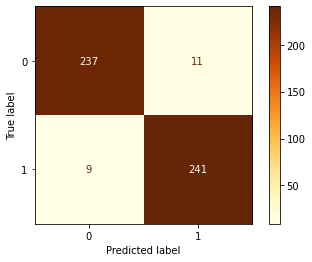

In [22]:
conf_matrix(X_test,gs_cvec_nb)

### Interpretation

Our main goals/concerns are to:

1. High accuracy of classification
2. Increase the True Negative count.
3. Reduce False Negative (Type II Error).
4. Increase Specificity score.
5. Increase Sensitivity score.

The reason is because type II Error would mean that a post from the subreddit 'Keto' is being classified as 'Vegan'.
Ethical vegans strongly believe that all creatures have the right to life and freedom. Therefore, they oppose ending a conscious being's life simply to consume its flesh, drink its milk, or wear its skin — especially because alternatives are available. Whereas Keto diet consist of about 75% fat, 10-30% protein and no more than 5% or 20 to 50 grams of carbs per day. Focus on high-fat, low-carb foods like **eggs, meats, dairy** and low-carb vegetables, as well as sugar-free beverages. Therefore, it would be disastrous to classify a Keto post as Vegan. 

The score of this model is:
- Accuracy: 0.9598
- True Negative: 237
- False Negative: 9
- Specificity: 0.9556
- Sensivitity: 0.964

The training and test accuracy scores for this model are 96.92%, 95.98% respectively indicating that the model is well fitted as the scores are fairly similar, the false negative count indicates that 9 keto posts are wrongly classified as vegan and true negative count indicates the number of vegan post predicted correctly. Specificity score is at 95.56% indicating the accuracy of predicted vegan posts that were correctly identified. Sensitivity score is at 96.4%, representing the number of Keto posts being indentified correctly.

### Using tf-idf vectorizer with Multinomial Naive Bayes

In [23]:
# Creating a pipeline with tf-idf vectorizer as the transformer and multinomialnb as the estimator
pipe_tfid_nb = Pipeline([
    ('tfid',TfidfVectorizer()),
    ('nbm',MultinomialNB())
])

In [24]:
pipe_params_tfid_nb = {
    'tfid__max_features': [400,800,1200,1600,2000],
    'tfid__min_df': [2, 3],
    'tfid__max_df': [.9, .95],
    'tfid__stop_words': [None,stop_words],
    'tfid__ngram_range': [(1,1), (1,2),(1,3)]
}



In [25]:
gs_tfid_nb = GridSearchCV(pipe_tfid_nb, # Pipeline that we created
                 param_grid = pipe_params_tfid_nb, # using the customized params that we want to search over
                 cv = 5, # 5-fold cross-validation.
                 verbose =1,
                         n_jobs=-1) 

In [26]:
gs_tfid_nb.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  2.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfid', TfidfVectorizer()),
                                       ('nbm', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tfid__max_df': [0.9, 0.95],
                         'tfid__max_features': [400, 800, 1200, 1600, 2000],
                         'tfid__min_df': [2, 3],
                         'tfid__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tfid__stop_words': [None,
                                              frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                      

In [27]:
gs_tfid_nb.best_score_

0.9544881147448991

In [28]:
gs_tfid_nb.score(X_train, y_train)

0.9678714859437751

In [29]:
gs_tfid_nb.score(X_test, y_test)

0.9538152610441767

In [30]:
gs_tfid_nb.best_params_

{'tfid__max_df': 0.9,
 'tfid__max_features': 1600,
 'tfid__min_df': 2,
 'tfid__ngram_range': (1, 2),
 'tfid__stop_words': frozenset({'a',
            'about',
            'above',
            'across',
            'after',
            'afterwards',
            'again',
            'against',
            'all',
            'almost',
            'alone',
            'along',
            'already',
            'also',
            'although',
            'always',
            'am',
            'among',
            'amongst',
            'amoungst',
            'amount',
            'amp',
            'an',
            'and',
            'another',
            'any',
            'anyhow',
            'anyone',
            'anything',
            'anyway',
            'anywhere',
            'are',
            'around',
            'as',
            'at',
            'back',
            'be',
            'became',
            'because',
            'become',
            'becomes',
          

In [31]:
#Creating a dataframe to show the best rank score from the different params
score2_df = pd.DataFrame(gs_tfid_nb.cv_results_).sort_values('rank_test_score')

score2_df = score2_df[['param_tfid__max_df', 'param_tfid__max_features', 'param_tfid__min_df',
       'param_tfid__ngram_range', 'mean_test_score','rank_test_score']]
score2_df

,param_tfid__max_df,param_tfid__max_features,param_tfid__min_df,param_tfid__ngram_range,mean_test_score,rank_test_score
39,0.9,1600,2,"(1, 2)",0.954488,1
99,0.95,1600,2,"(1, 2)",0.954488,1
107,0.95,1600,3,"(1, 3)",0.953819,3
47,0.9,1600,3,"(1, 3)",0.953819,3
105,0.95,1600,3,"(1, 2)",0.953817,5
...,...,...,...,...,...,...
104,0.95,1600,3,"(1, 2)",0.936412,116
44,0.9,1600,3,"(1, 2)",0.936412,116
80,0.95,800,3,"(1, 2)",0.936408,118
92,0.95,1200,3,"(1, 2)",0.936408,119


True Negatives: 234
False Positives: 14
False Negatives: 9
True Positives: 241

Accuracy: 0.9538152610441767
Misclassification: 0.04618473895582331
Precision: 0.9450980392156862
Sensitivity: 0.964
Specificity: 0.9435483870967742


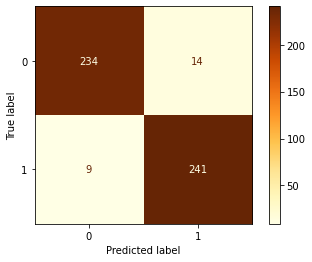

In [32]:
conf_matrix(X_test,gs_tfid_nb)

### Interpretation

The scores of this model are:
- Accuracy: 0.9538
- True Negative: 234
- False Negative: 9
- Specificity: 0.9435
- Sensitivity: 0.964

The training and test accuracy scores for this model are 96.78%, 95.38% respectively indicating that the model is well fitted as both scores are fairly similar, the false negative count retain at 9 but true negative count has also drop to 234. This indicates that more Vegan post are wrongly classified as Keto. Specificity score also dropped to 94.35% as mentioned previously that true negative count has dropped and sensitivity retained at 96.4%.


## KNearestNeighbors model

KNN works by finding the distances between a query and all the examples in the data, selecting the specified number examples (K) closest to the query, then votes for the most frequent label (in the case of classification)

### Using Count vectorizer with KNeighborsClassifier

In [33]:
# Creating a pipeline with countvectorizer as the transformer and K-NearestNeighbors as the estimator
pipe_cvec_knn = Pipeline([
    ('cvec',CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [34]:
pipe_params_cvec_knn = {
    'cvec__max_features': [1200,1600,2000],
    'cvec__min_df': [2],
    'cvec__max_df': [.9, .95],
    'cvec__stop_words': [stop_words],
    'cvec__ngram_range': [(1,1), (1,2)],
    'knn__p': [1, 2], 
    'knn__weights': ['uniform', 'distance'],
    'knn__n_neighbors': [3, 5]
}

In [35]:
gs_cvec_knn = GridSearchCV(pipe_cvec_knn, # Pipeline that we creating
                         param_grid = pipe_params_cvec_knn, # Using the customized params that we want to search over
                         cv = 5, # 5-fold cross validation
                         verbose=1,
                           n_jobs = -1
)

In [36]:
gs_cvec_knn.fit(X_train,y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.4min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [1200, 1600, 2000],
                         'cvec__min_df': [2],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                                           

In [37]:
gs_cvec_knn.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 1200,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': frozenset({'a',
            'about',
            'above',
            'across',
            'after',
            'afterwards',
            'again',
            'against',
            'all',
            'almost',
            'alone',
            'along',
            'already',
            'also',
            'although',
            'always',
            'am',
            'among',
            'amongst',
            'amoungst',
            'amount',
            'amp',
            'an',
            'and',
            'another',
            'any',
            'anyhow',
            'anyone',
            'anything',
            'anyway',
            'anywhere',
            'are',
            'around',
            'as',
            'at',
            'back',
            'be',
            'became',
            'because',
            'become',
            'becomes',
          

In [38]:
gs_cvec_knn.best_score_

0.8293259410563175

In [39]:
# Training score
gs_cvec_knn.score(X_train,y_train)

0.8755020080321285

In [40]:
# Test score
gs_cvec_knn.score(X_test,y_test)

0.8112449799196787

In [41]:
#Creating a dataframe to show the best rank score from the different params
score3_df = pd.DataFrame(gs_cvec_knn.cv_results_).sort_values('rank_test_score')

score3_df = score3_df[['param_cvec__max_df', 'param_cvec__max_features', 'param_cvec__min_df',
       'param_cvec__ngram_range', 'param_knn__n_neighbors', 'param_knn__p','param_knn__weights', 'mean_test_score','rank_test_score']]
score3_df

,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_knn__n_neighbors,param_knn__p,param_knn__weights,mean_test_score,rank_test_score
62,0.95,1200,2,"(1, 2)",5,2,uniform,0.829326,1
15,0.9,1200,2,"(1, 2)",5,2,distance,0.829326,1
14,0.9,1200,2,"(1, 2)",5,2,uniform,0.829326,1
63,0.95,1200,2,"(1, 2)",5,2,distance,0.829326,1
51,0.95,1200,2,"(1, 1)",3,2,distance,0.825326,5
...,...,...,...,...,...,...,...,...,...
92,0.95,2000,2,"(1, 2)",5,1,uniform,0.598413,91
41,0.9,2000,2,"(1, 2)",3,1,distance,0.572286,93
89,0.95,2000,2,"(1, 2)",3,1,distance,0.572286,93
40,0.9,2000,2,"(1, 2)",3,1,uniform,0.571617,95


hese are the top 5 results of GridSearchCV with customized cvec parameters and KNearestNeighbors. The cvec params that were customized are the same, 

- param_knn_n_neighbors: Number of neighbors to use. With reference to the first ranking model, 5 neighbors were used in that model.

- param_knn_p: The type of metric used where 2 represents euclidean_distance.

- param_knn_weights: Uniform representing all points in each neighborhood are weighted equally whereas Distance weight points by the inverse of their distance, closer neighbors of a query point will have a greater influence than neighbors which are further away.

True Negatives: 241
False Positives: 7
False Negatives: 87
True Positives: 163

Accuracy: 0.8112449799196787
Misclassification: 0.1887550200803213
Precision: 0.9588235294117647
Sensitivity: 0.652
Specificity: 0.9717741935483871


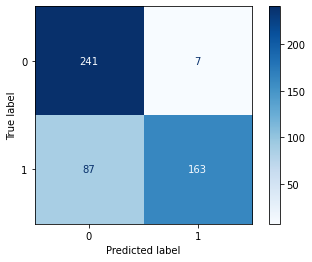

In [42]:
conf_matrix(X_test,gs_cvec_knn,'Blues')

### Interpretation

- Accuracy: 0.8112
- True Negative: 241
- False Negative: 87
- Specificity: 0.9717
- Sensitivity: 0.652

The training and test accuracy scores for this model are 87.55% and 81.12% respectively suggesting that the model is overfitted. The false negative count have increase to 87 contributing to the drop in sensitivity score to 65.2%. This is a fairly bad model as other than the false positive count moving in the right direction, all other counts were going towards the opposite direction. 


### Using tf-idf vectorizer with KNeighborsClassifier

In [43]:
# Creating a pipeline with tf-idf vectorizer as the transformer and K-NearestNeighbors as the estimator
pipe_tfid_knn = Pipeline([
    ('tfid',TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [44]:
pipe_params_tfid_knn = {
    'tfid__max_features': [1200,1600,2000],
    'tfid__min_df': [2],
    'tfid__max_df': [.9, .95],
    'tfid__stop_words': [stop_words],
    'tfid__ngram_range': [(1,1), (1,2)],
    'knn__p': [1, 2], 
    'knn__weights': ['uniform', 'distance'],
    'knn__n_neighbors': [3, 5]
}

In [45]:
gs_tfid_knn = GridSearchCV(pipe_tfid_knn, # Pipeline that we created
                         param_grid = pipe_params_tfid_knn, # Using the customized params that we want to search over
                         cv = 5, # 5-fold cross validation
                         verbose=1,
                           n_jobs=-1
)

In [46]:
gs_tfid_knn.fit(X_train,y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfid', TfidfVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [3, 5], 'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance'],
                         'tfid__max_df': [0.9, 0.95],
                         'tfid__max_features': [1200, 1600, 2000],
                         'tfid__min_df': [2],
                         'tfid__ngram_range': [(1, 1), (1, 2)],
                         'tfid__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'al

In [47]:
gs_tfid_knn.best_params_

{'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'distance',
 'tfid__max_df': 0.9,
 'tfid__max_features': 2000,
 'tfid__min_df': 2,
 'tfid__ngram_range': (1, 2),
 'tfid__stop_words': frozenset({'a',
            'about',
            'above',
            'across',
            'after',
            'afterwards',
            'again',
            'against',
            'all',
            'almost',
            'alone',
            'along',
            'already',
            'also',
            'although',
            'always',
            'am',
            'among',
            'amongst',
            'amoungst',
            'amount',
            'amp',
            'an',
            'and',
            'another',
            'any',
            'anyhow',
            'anyone',
            'anything',
            'anyway',
            'anywhere',
            'are',
            'around',
            'as',
            'at',
            'back',
            'be',
            'became',
           

In [48]:
gs_tfid_knn.best_score_

0.9196830598639762

In [49]:
# Training score
gs_tfid_knn.score(X_train,y_train)

1.0

In [50]:
# Test score
gs_tfid_knn.score(X_test,y_test)

0.9236947791164659

In [51]:
#Creating a dataframe to show the best rank score from the different params
score4_df = pd.DataFrame(gs_tfid_knn.cv_results_).sort_values('rank_test_score')

score4_df = score4_df[['param_tfid__max_df', 'param_tfid__max_features', 'param_tfid__min_df',
       'param_tfid__ngram_range', 'param_knn__n_neighbors', 'param_knn__p','param_knn__weights', 'mean_test_score','rank_test_score']]
score4_df

,param_tfid__max_df,param_tfid__max_features,param_tfid__min_df,param_tfid__ngram_range,param_knn__n_neighbors,param_knn__p,param_knn__weights,mean_test_score,rank_test_score
95,0.95,2000,2,"(1, 2)",5,2,distance,0.919683,1
89,0.9,2000,2,"(1, 2)",5,2,distance,0.919683,1
83,0.95,2000,2,"(1, 2)",5,2,uniform,0.919014,3
77,0.9,2000,2,"(1, 2)",5,2,uniform,0.919014,3
93,0.95,1600,2,"(1, 2)",5,2,distance,0.918350,5
...,...,...,...,...,...,...,...,...,...
15,0.9,1600,2,"(1, 2)",3,1,distance,0.567612,91
3,0.9,1600,2,"(1, 2)",3,1,uniform,0.566275,93
9,0.95,1600,2,"(1, 2)",3,1,uniform,0.566275,93
58,0.95,2000,2,"(1, 1)",5,1,uniform,0.565586,95


True Negatives: 227
False Positives: 21
False Negatives: 17
True Positives: 233

Accuracy: 0.9236947791164659
Misclassification: 0.07630522088353409
Precision: 0.9173228346456693
Sensitivity: 0.932
Specificity: 0.9153225806451613


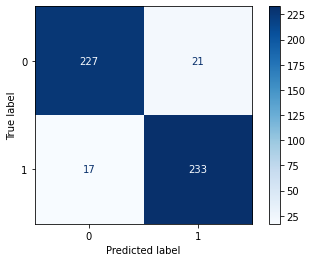

In [52]:
conf_matrix(X_test,gs_tfid_knn,'Blues')

### Interpretation

- Accuracy: 0.9236
- True Negative: 227
- False Negative: 17
- Specificity: 0.9153
- Sensitivity: 0.932

The training and test accuracy scores for this model are 100%, 92.36% respectively indicating that the model is overfitted.
The false negative count has dropped to 17 as compared to the previous model, contributing to the rise of sensitivity score to 93.2%. Specificity score is at 91.53% indicating the accuracy of predicted vegan posts that were correctly identified.

## Random Forest

The random forest is a classification algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree.

### Using Countvectorizer with RandomForest

In [53]:
# Creating a pipeline with countvectorizer as the transformer and Random Forest as the estimator
pipe_cvec_rf = Pipeline([
    ('cvec',CountVectorizer()),
    ('rf', RandomForestClassifier())
])


In [54]:
pipe_params_cvec_rf = {
    'cvec__max_features': [1200,1600,2000],
    'cvec__min_df': [2],
    'cvec__max_df': [.9],
    'cvec__stop_words': [stop_words],
    'cvec__ngram_range': [(1,2)],
    'rf__n_estimators': [100,150,200],
    'rf__max_depth': [1,2,3,4,5],
    'rf__max_features':['auto','log2',1/3],
    'rf__random_state': [42]
}

In [55]:
gs_cvec_rf = GridSearchCV(pipe_cvec_rf, # Pipeline that we created
                          param_grid= pipe_params_cvec_rf, # Using the customized params that we want to search over
                          cv=5, # 5-fold cross validation
                          verbose=1,
                          n_jobs=-1)

In [56]:
gs_cvec_rf.fit(X_train,y_train)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed:  3.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9],
                         'cvec__max_features': [1200, 1600, 2000],
                         'cvec__min_df': [2], 'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                                                         'always', 'am',
        

In [57]:
gs_cvec_rf.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 1600,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': frozenset({'a',
            'about',
            'above',
            'across',
            'after',
            'afterwards',
            'again',
            'against',
            'all',
            'almost',
            'alone',
            'along',
            'already',
            'also',
            'although',
            'always',
            'am',
            'among',
            'amongst',
            'amoungst',
            'amount',
            'amp',
            'an',
            'and',
            'another',
            'any',
            'anyhow',
            'anyone',
            'anything',
            'anyway',
            'anywhere',
            'are',
            'around',
            'as',
            'at',
            'back',
            'be',
            'became',
            'because',
            'become',
            'becomes',
          

In [58]:
gs_cvec_rf.best_score_

0.9578438194428858

In [59]:
# Training score
gs_cvec_rf.score(X_train,y_train)

0.963855421686747

In [60]:
# Test score
gs_cvec_rf.score(X_test,y_test)

0.9658634538152611

In [61]:
#Creating a dataframe to show the best rank score from the different params
score5_df = pd.DataFrame(gs_cvec_rf.cv_results_).sort_values('rank_test_score')

score5_df = score5_df[['param_cvec__max_df', 'param_cvec__max_features', 'param_cvec__min_df',
       'param_cvec__ngram_range','param_rf__max_depth', 'param_rf__max_features',
       'param_rf__n_estimators' ,'mean_test_score','rank_test_score']]
score5_df

,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_rf__max_depth,param_rf__max_features,param_rf__n_estimators,mean_test_score,rank_test_score
47,0.9,1600,2,"(1, 2)",1,auto,200,0.957844,1
37,0.9,1200,2,"(1, 2)",5,auto,150,0.957842,2
56,0.9,1600,2,"(1, 2)",2,auto,200,0.957175,3
109,0.9,2000,2,"(1, 2)",3,auto,150,0.957173,4
40,0.9,1200,2,"(1, 2)",5,log2,150,0.957168,5
...,...,...,...,...,...,...,...,...,...
48,0.9,1600,2,"(1, 2)",1,log2,100,0.910339,131
95,0.9,2000,2,"(1, 2)",1,log2,200,0.898925,132
102,0.9,2000,2,"(1, 2)",2,log2,100,0.896249,133
94,0.9,2000,2,"(1, 2)",1,log2,150,0.878847,134


These are the top 5 results of GridSearchCV with customized cvec parameters and Random Forest. Using the same customized cvec parameters, let us go through the random forest parameters that were customized:

- param_rf_max_depth: The maximum depth of the tree. Using the first ranking model, this means that the model has a depth of 4.

- param_rf_max_features: The number of features to consider when looking for the best split:
  - If float, then `max_features` is a fraction and `int(max_features * n_features)` features are considered at each split.
  - If "auto", then `max_features=sqrt(n_features)`.
  - If "sqrt", then `max_features=sqrt(n_features)` (same as "auto").
  - If "log2", then `max_features=log2(n_features)`.

  The first ranking model uses auto which means its the square root of the number of features.


- param_rf_n_estimators: The number of trees in the forest. Referencing from the first ranking model, there are 200 trees in the model.

True Negatives: 238
False Positives: 10
False Negatives: 7
True Positives: 243

Accuracy: 0.9658634538152611
Misclassification: 0.034136546184738936
Precision: 0.9604743083003953
Sensitivity: 0.972
Specificity: 0.9596774193548387


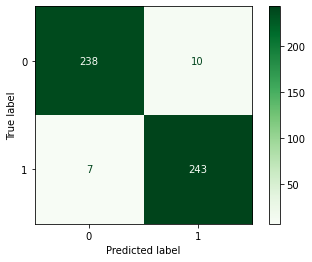

In [62]:
conf_matrix(X_test,gs_cvec_rf,'Greens')

### Interpretation

- Accuracy: 0.9658
- True Negative: 238
- False Negative: 7
- Specificity: 0.9596
- Sensitivity: 0.972

The training and test accuracy scores for this model are 96.38% and 96.58% respectively indicating that the model is well fitted as the scores are very similar. The false negative count have improved to 7 which probably carried the sensitivity score to 97.20% which is the highest compared to the other previous models. The predicted vegan post that were correctly identified(True negative) is at 238 and specificity score 95.96%. 


### Using tf-idf vectorizer with RandomForest

In [63]:
# Creating a pipeline with tf-idf vectorizer as the transformer and Random Forest as the estimator
pipe_tfid_rf = Pipeline([
    ('tfid',TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])


In [64]:
pipe_params_tfid_rf = {
    'tfid__max_features': [1200,1600,2000],
    'tfid__min_df': [2],
    'tfid__max_df': [.9],
    'tfid__stop_words': [stop_words],
    'tfid__ngram_range': [(1,2)],
    'rf__n_estimators': [100,150,200],
    'rf__max_depth': [1,2,3,4,5],
    'rf__max_features':['auto','log2',1/3],
    'rf__random_state':[42]
}

In [65]:
gs_tfid_rf = GridSearchCV(pipe_tfid_rf, # Pipeline that we created
                          param_grid= pipe_params_tfid_rf, #Using the customized params that we want to search over
                          cv=5, # 5-fold cross-validation
                          verbose=1,
                          n_jobs=-1)

In [66]:
gs_tfid_rf.fit(X_train,y_train)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed:  4.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfid', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [1, 2, 3, 4, 5],
                         'rf__max_features': ['auto', 'log2',
                                              0.3333333333333333],
                         'rf__n_estimators': [100, 150, 200],
                         'rf__random_state': [42], 'tfid__max_df': [0.9],
                         'tfid__max_features': [1200, 1600, 2000],
                         'tfid__min_df': [2], 'tfid__ngram_range': [(1, 2)],
                         'tfid__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                   

In [67]:
gs_tfid_rf.best_params_

{'rf__max_depth': 2,
 'rf__max_features': 'auto',
 'rf__n_estimators': 200,
 'rf__random_state': 42,
 'tfid__max_df': 0.9,
 'tfid__max_features': 1600,
 'tfid__min_df': 2,
 'tfid__ngram_range': (1, 2),
 'tfid__stop_words': frozenset({'a',
            'about',
            'above',
            'across',
            'after',
            'afterwards',
            'again',
            'against',
            'all',
            'almost',
            'alone',
            'along',
            'already',
            'also',
            'although',
            'always',
            'am',
            'among',
            'amongst',
            'amoungst',
            'amount',
            'amp',
            'an',
            'and',
            'another',
            'any',
            'anyhow',
            'anyone',
            'anything',
            'anyway',
            'anywhere',
            'are',
            'around',
            'as',
            'at',
            'back',
            'be',

In [68]:
gs_tfid_rf.best_score_

0.9598527530246235

In [69]:
gs_tfid_rf.score(X_train,y_train)

0.964524765729585

In [70]:
gs_tfid_rf.score(X_test,y_test)

0.9698795180722891

In [71]:
#Creating a dataframe to show the best rank score from the different params
score6_df = pd.DataFrame(gs_tfid_rf.cv_results_).sort_values('rank_test_score')

score6_df = score6_df[['param_tfid__max_df', 'param_tfid__max_features', 'param_tfid__min_df',
       'param_tfid__ngram_range','param_rf__max_depth', 'param_rf__max_features',
       'param_rf__n_estimators', 'mean_test_score','rank_test_score']]
score6_df

,param_tfid__max_df,param_tfid__max_features,param_tfid__min_df,param_tfid__ngram_range,param_rf__max_depth,param_rf__max_features,param_rf__n_estimators,mean_test_score,rank_test_score
34,0.9,1600,2,"(1, 2)",2,auto,200,0.959853,1
111,0.9,1200,2,"(1, 2)",5,auto,150,0.958510,2
114,0.9,1200,2,"(1, 2)",5,auto,200,0.958510,2
84,0.9,1200,2,"(1, 2)",4,auto,150,0.957842,4
108,0.9,1200,2,"(1, 2)",5,auto,100,0.957842,4
...,...,...,...,...,...,...,...,...,...
9,0.9,1200,2,"(1, 2)",1,log2,100,0.908978,131
38,0.9,2000,2,"(1, 2)",2,log2,100,0.901616,132
17,0.9,2000,2,"(1, 2)",1,log2,200,0.884847,133
14,0.9,2000,2,"(1, 2)",1,log2,150,0.864118,134


True Negatives: 243
False Positives: 5
False Negatives: 10
True Positives: 240

Accuracy: 0.9698795180722891
Misclassification: 0.030120481927710885
Precision: 0.9795918367346939
Sensitivity: 0.96
Specificity: 0.9798387096774194


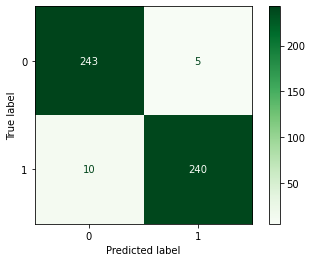

In [72]:
conf_matrix(X_test,gs_tfid_rf,'Greens')

### Interpretation

- Accuracy: 0.9698
- True Negative: 243
- False Negative: 10
- Specificity: 0.9798
- Sensitivity: 0.96

The training and test accuracy scores for this model are 96.45%, 96.98% respectively indicating that the model is well fitted as the scores are very similar. The true negative count and specificity score are decently well at 243 and 97.98%.
Pairing it with low False negative count and high sensitivity score at 10 and 96%.

## Score Summary 

|                   Model |       Transformer | Training Score | Test Score | Specificity | Sensitivity | True Negative | False Positive | False Negative | True Positive |
|------------------------:|------------------:|---------------:|-----------:|------------:|------------:|--------------:|---------------:|---------------:|--------------:|
|                Baseline |                 - |         0.5020 |          - |           - |           - |             - |              - |              - |             - |
| Multinomial Naive Bayes |   CountVectorizer |         0.9692 |     0.9598 |      0.9556 |      0.9640 |           237 |             11 |              9 |           241 |
| Multinomial Naive Bayes | TF-IDF Vectorizer |         0.9678 |     0.9538 |      0.9435 |      0.9640 |           234 |             14 |              9 |           241 |
|       KNearestNeighbors |   CountVectorizer |         0.8755 |     0.8112 |      0.9717 |      0.6520 |           241 |              7 |             87 |           163 |
|       KNearestNeighbors | TF-IDF Vectorizer |            1.0 |     0.9236 |      0.9153 |      0.9320 |           227 |             21 |             17 |           233 |
|           Random Forest |   CountVectorizer |         0.9638 |     0.9658 |      0.9596 |      0.9720 |           238 |             10 |              7 |           243 |
|           Random Forest | TF-IDF Vectorizer |         0.9645 |     0.9698 |      0.9798 |      0.9600 |           243 |              5 |             10 |           240 |

## Conclusion


To revisit what our main goals/concerns are:

- High accuracy of classification
- Increase the True Negative count.
- Reduce False Negative (Type II Error).
- Increase Specificity score.
- Increase Sensitivity score.

My model of choice would be the Second last model, Random Forest paired with Countvectorizer. Reason being is that 
even though the last model (Random forest with TF-IDF Vectorizer) had achieve slightly better scores on some aspects, The chosen model had better scores on *True Positive count* ,*False Negative count* and *sensitivity score*.

 - A higher *True Positive count* would dictate that more Keto posts are predicted correctly. 
 - A lower *False Negative count* would dictate that lesser predicted Keto post to be Vegan.
 - A higher *Sensitivity score* would dictate accuracy of Keto posts that were correctly identified. 

To refresh our memory:

These scores are crucial as ethical vegans have strong beliefs that all creatures have the right to life and freedom. Therefore, they oppose ending a conscious being's life simply to consume its flesh, drink its milk, or wear its skin — especially because alternatives are available. And people who are into Keto do not have any concern where they get their nutrition from, be it plants or animals as long as their nutrition requirement has been fulfilled. Therefore we take the mentioned scores into serious consideration to mitigate the risk of Keto posts being classified as Vegan for our client.   

However, as there are still room for improvement in the model that we have explored. We can further improve our model with more data (posts being scrapped) or even increase the time horizon of the data scrapped to probably 2-3 years post's age. This is because forums usually have lingos so we might be able to capture such lingos used in different subreddit to help increase the accuracy. We can also explore using boosting in models such as XGBoost to see if they yield better results.